<a href="https://colab.research.google.com/github/mrzResearchArena/TF-2.X/blob/master/Finalized-ACP-740.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Google Drive Initialization:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ls

drive/  sample_data/


In [0]:
cd 'drive/My Drive/Colab-Notebooks'

/content/drive/My Drive/Colab-Notebooks


In [0]:
ls -1

0_FINAL_anti_peptide_model_AC240-tensorboard.ipynb
0_FINAL_anti_peptide_model_ACP740-tensorboard.ipynb
544_encoded_sequences_740.npy
ACP240_labels.npy
acp240.txt
ACP740_labels.npy
ACP-740-tensorboard.ipynb
acp740.txt
blosum62-acp240.npy
blosum62-acp740.npy
BPF_coded_ACP240_sequences.npy
BPF_coded_ACP740_sequences.npy
kmer_k_3_ACP240.npy
kmer_k_3_ACP740.npy
logs/
mACP-240.ipynb
mACP-740.ipynb
model-240.png
model-740.png
model.png
multichannel.png
physico_coded_ACP240_sequences.npy
physico_coded_ACP740_sequences.npy


## 2. Load Deep Learning API (Keras):

In [0]:
# Deep Neural Networks:
from keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                          Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, concatenate,
                          SimpleRNN, LSTM, GRU, Bidirectional, Embedding)
from keras.regularizers import (l1, l2, l1_l2)
from keras.optimizers import (RMSprop, Adam, SGD)
from keras.models import (Sequential, Model)
import keras; print('We\'re using Keras version: {}.'.format(keras.__version__))

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, mean_squared_error, 
                             matthews_corrcoef, precision_score)

#Utilities
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import to_categorical as labelEncoding # Usages: Ytrain = labelEncoding(Ytrain, dtype=int)
from keras.utils import plot_model                      # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)
#end-import

We're using Keras version: 2.2.5.


## 3. Load Datasets:

In [0]:
D = 26 # terminus_length

X1 = np.load('BPF_coded_ACP740_sequences.npy')
X2 = np.load('physico_coded_ACP740_sequences.npy')
X3 = np.load('blosum62-acp740.npy')

X3 = X3.reshape(-1, 20, 11)

Y = np.load('ACP740_labels.npy')
Y = labelEncoding(Y, dtype=int)


print(X1.shape)
print(X2.shape)
print(X3.shape)
print(Y.shape)


X1 = X1[:,:,0:D]
X2 = X2[:,:,0:D]
X3 = X3[:,:,:]
print('### --- --- ###')


print(X1.shape)
print(X2.shape)
print(X3.shape)
print(Y.shape)

(740, 20, 207)
(740, 7, 97)
(740, 20, 11)
(740, 2)
### --- --- ###
(740, 20, 26)
(740, 7, 26)
(740, 20, 11)
(740, 2)


## 4. Generate Model:

In [0]:
def Network():
    ### Head-1:
    input1 = Input(shape=(20, D)) # T=20

    x = Conv1D(filters=32, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    head1 = Flatten()(x)


    ### Head-2:
    input2 = Input(shape=(7, D)) # T=7

    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(input2)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=4, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    head2 = Flatten()(x)


    ### Head-3:
    input3 = Input(shape=(20, 11)) 
    
    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(input3)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=12, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    head3 = Flatten()(x)


    # merge
    merge = concatenate(inputs=[head1, head2, head3])

    output = Dense(units=16, activation='relu',)(merge)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.5)(output)

    output = Dense(units=8, activation='relu',)(output)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.5)(output)

    output = Dense(units=2, activation='softmax')(output)

    return Model(inputs=[input1, input2, input3], outputs=[output])
#end-def

Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_156 (InputLayer)          (None, 20, 26)       0                                            
__________________________________________________________________________________________________
input_157 (InputLayer)          (None, 7, 26)        0                                            
__________________________________________________________________________________________________
input_158 (InputLayer)          (None, 20, 11)       0                                            
__________________________________________________________________________________________________
conv1d_466 (Conv1D)             (None, 32, 26)       1952        input_156[0][0]                  
___________________________________________________________________________________________

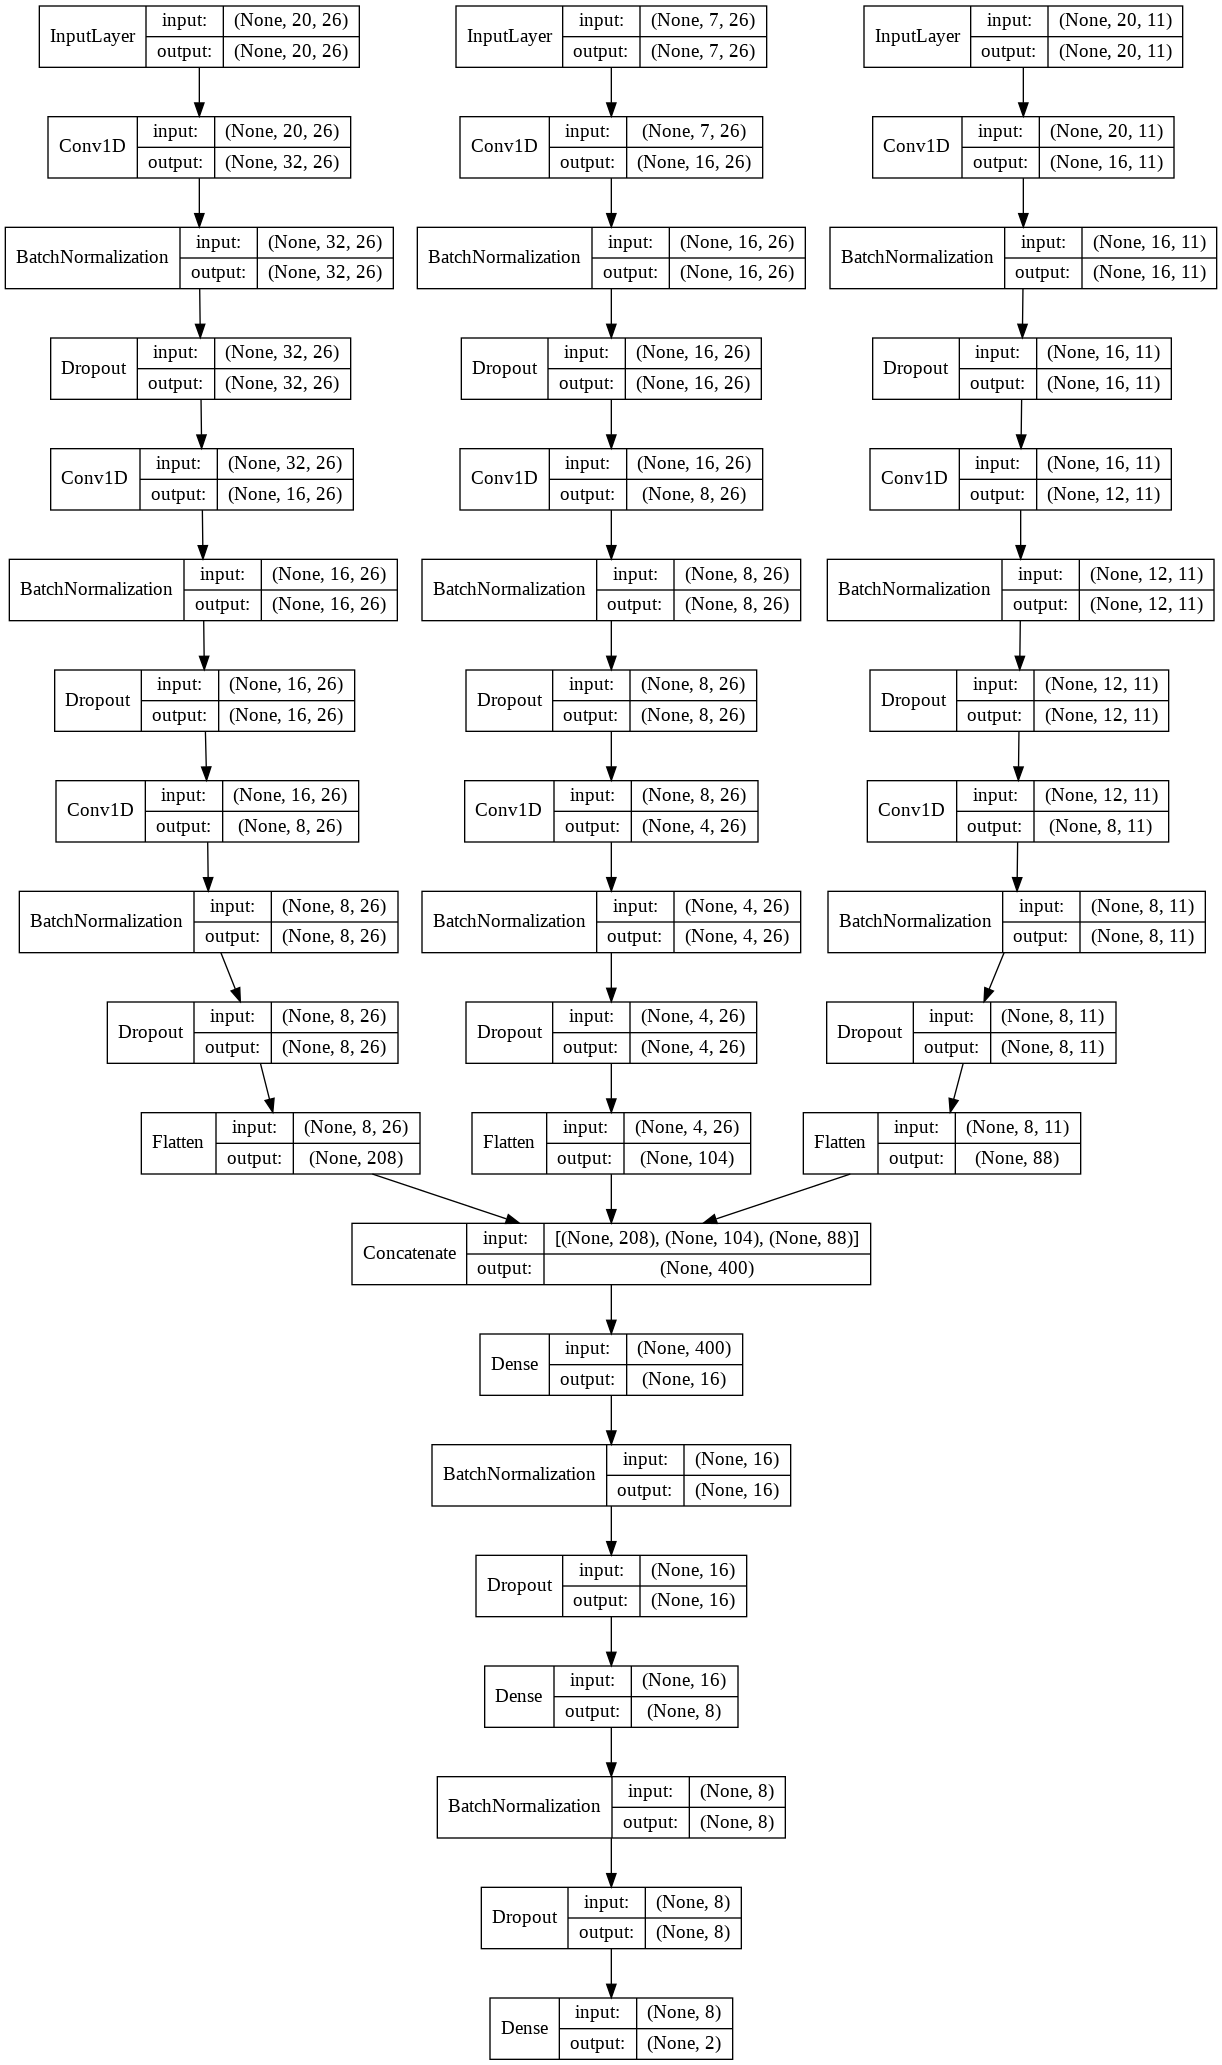

In [0]:
model = Network()
model.summary()
plot_model(model, to_file='model-740.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [0]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['acc'], label='Training Accuracy')
    plt.plot(results.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

## Set Epoch and Batch Size:

In [0]:
setEpochNumber     = 1000     # 2,500 performed well.
setBatchSizeNumber = 16

## 6. Run Model:

Train on 592 samples, validate on 148 samples
Epoch 1/1000
592/592 [==============================] - 49s 83ms/step - loss: 1.3270 - acc: 0.5000 - val_loss: 0.7833 - val_acc: 0.5405
Epoch 2/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.1762 - acc: 0.5068 - val_loss: 0.7742 - val_acc: 0.5270
Epoch 3/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.2205 - acc: 0.5068 - val_loss: 0.7640 - val_acc: 0.5068
Epoch 4/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.2749 - acc: 0.4814 - val_loss: 0.7623 - val_acc: 0.5068
Epoch 5/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.1941 - acc: 0.4949 - val_loss: 0.7567 - val_acc: 0.5000
Epoch 6/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.2056 - acc: 0.4780 - val_loss: 0.7551 - val_acc: 0.4932
Epoch 7/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.2365 - acc: 0.4764 - val_loss: 0.7520 - val_acc: 0.5068
Epoch 8/1000
5

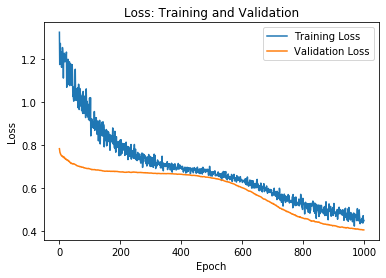

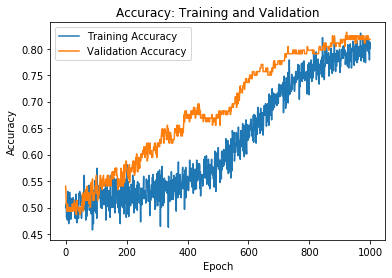

#################################################
Train on 592 samples, validate on 148 samples
Epoch 1/1000
592/592 [==============================] - 47s 80ms/step - loss: 1.4407 - acc: 0.4797 - val_loss: 0.7613 - val_acc: 0.4932
Epoch 2/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.5022 - acc: 0.4814 - val_loss: 0.7601 - val_acc: 0.4932
Epoch 3/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.5143 - acc: 0.4662 - val_loss: 0.7594 - val_acc: 0.4865
Epoch 4/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.3148 - acc: 0.5169 - val_loss: 0.7570 - val_acc: 0.5000
Epoch 5/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.2970 - acc: 0.5253 - val_loss: 0.7579 - val_acc: 0.5068
Epoch 6/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.4972 - acc: 0.4949 - val_loss: 0.7533 - val_acc: 0.5000
Epoch 7/1000
592/592 [==============================] - 1s 2ms/step - loss: 1.5296 - acc: 0.5034 -

In [0]:
cv = KFold(n_splits=5, shuffle=True)

Accuracy = []
Sensitivity = []
Specificity = []
Precision = []
MCC = []

# CM = np.array([
#      [0, 0],
#      [0, 0],
# ], dtype=int)

for train, test in cv.split(Y):

    # Compile Model:
    model = Network()
    model.compile(optimizer=Adam(lr=0.00005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Run Model:
    results = model.fit(x=[X1[train,:,:],X2[train,:,:],X3[train,:,:]], y=[Y[train,:]], validation_data=([X1[test,:,:], X2[test,:,:], X3[test,:,:]], [Y[test,:]]), epochs=setEpochNumber, batch_size=setBatchSizeNumber, verbose=1)

    # Evaluate the Model:
    accuracy = model.evaluate(x=[X1[test,:,:], X2[test,:,:], X3[test,:,:]], y=Y[test,:])
    Accuracy.append(accuracy[1])
    
    # Performance Metices:
    Yactual = Y[test,:].argmax(axis=1)
    Yp = model.predict([X1[test,:,:], X2[test,:,:], X3[test,:,:]])
    Yp = Yp.argmax(axis=1)

    CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
    TN, FP, FN, TP = CM.ravel()

    MCC.append(matthews_corrcoef(y_true=Yactual, y_pred=Yp))
    Sensitivity.append( TP / (TP + FN) )
    Specificity.append( TN / (TN + FP) )
    Precision.append(precision_score(y_true=Yactual, y_pred=Yp))
    
    
    # Performance Plot
    print('#################################################')
    print('Fold\'s Accuracy: {:.2f}'.format(accuracy[1]*100.0))
    lossPlot(results)
    accuracyPlot(results)
    print('#################################################')
#end-for

print(Accuracy)
print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/5.0))
print('Sensitivity: {0:.4f}'.format(np.sum(Sensitivity)/5.00))
print('Specificity: {0:.4f}'.format(np.sum(Specificity)/5.00))
print('MCC: {0:.4f}'.format(np.sum(MCC)/5.00))
print('Precision: {0:.4f}'.format(np.sum(Precision)/5.00))